# Cifar10

In this exercise we will try to create a CNN that will classify not 2 but 10 different image labels. We get the images from the dataset named [Cifar10](http://www.cs.utoronto.ca/~kriz/cifar.html) 

* Import :
  * pytorch
  * Numpy 
  * Matplotlib.pyplot 

In [30]:
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torchinfo import summary
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import zipfile
import torch.nn as nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


* Load the image files into your storage with this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip`

In [ ]:

# Define the URL and the output path
url = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip"
output_path = "cifar-10.zip"
extract_dir = "./cifar-10"
def load_and_extract_files(url,output_path,extract_dir):
    # Download the dataset
    if not os.path.exists(output_path):
        response = requests.get(url, stream=True)
        with open(output_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    # Extract the dataset
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(output_path, "r") as zip_ref:
            zip_ref.extractall(f"./{extract_dir}")
        print("Extraction complete.")

load_and_extract_files(url,output_path,extract_dir)

Download complete.
Extraction complete.


* Import the dataframe containing the labels from this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv`

* Turn the `id` column into string type and add `.png` at the end of each string for the filenames to be complete

In [ ]:
data = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")
data["id"] = data["id"].astype(str) + ".png"
data.head()

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


* Load and display an image of your dataset 

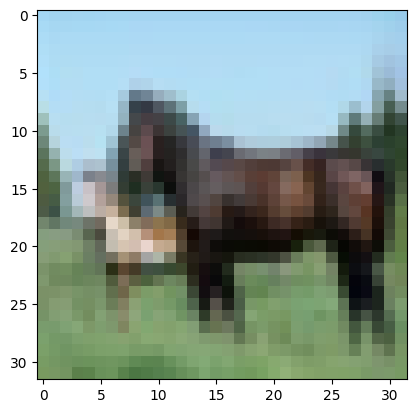

In [8]:
image = Image.open("./train/13.png")

plt.imshow(image)
plt.show()

* View a random image of each of your labels in your dataset * View a random image of each of your labels in your dataset 

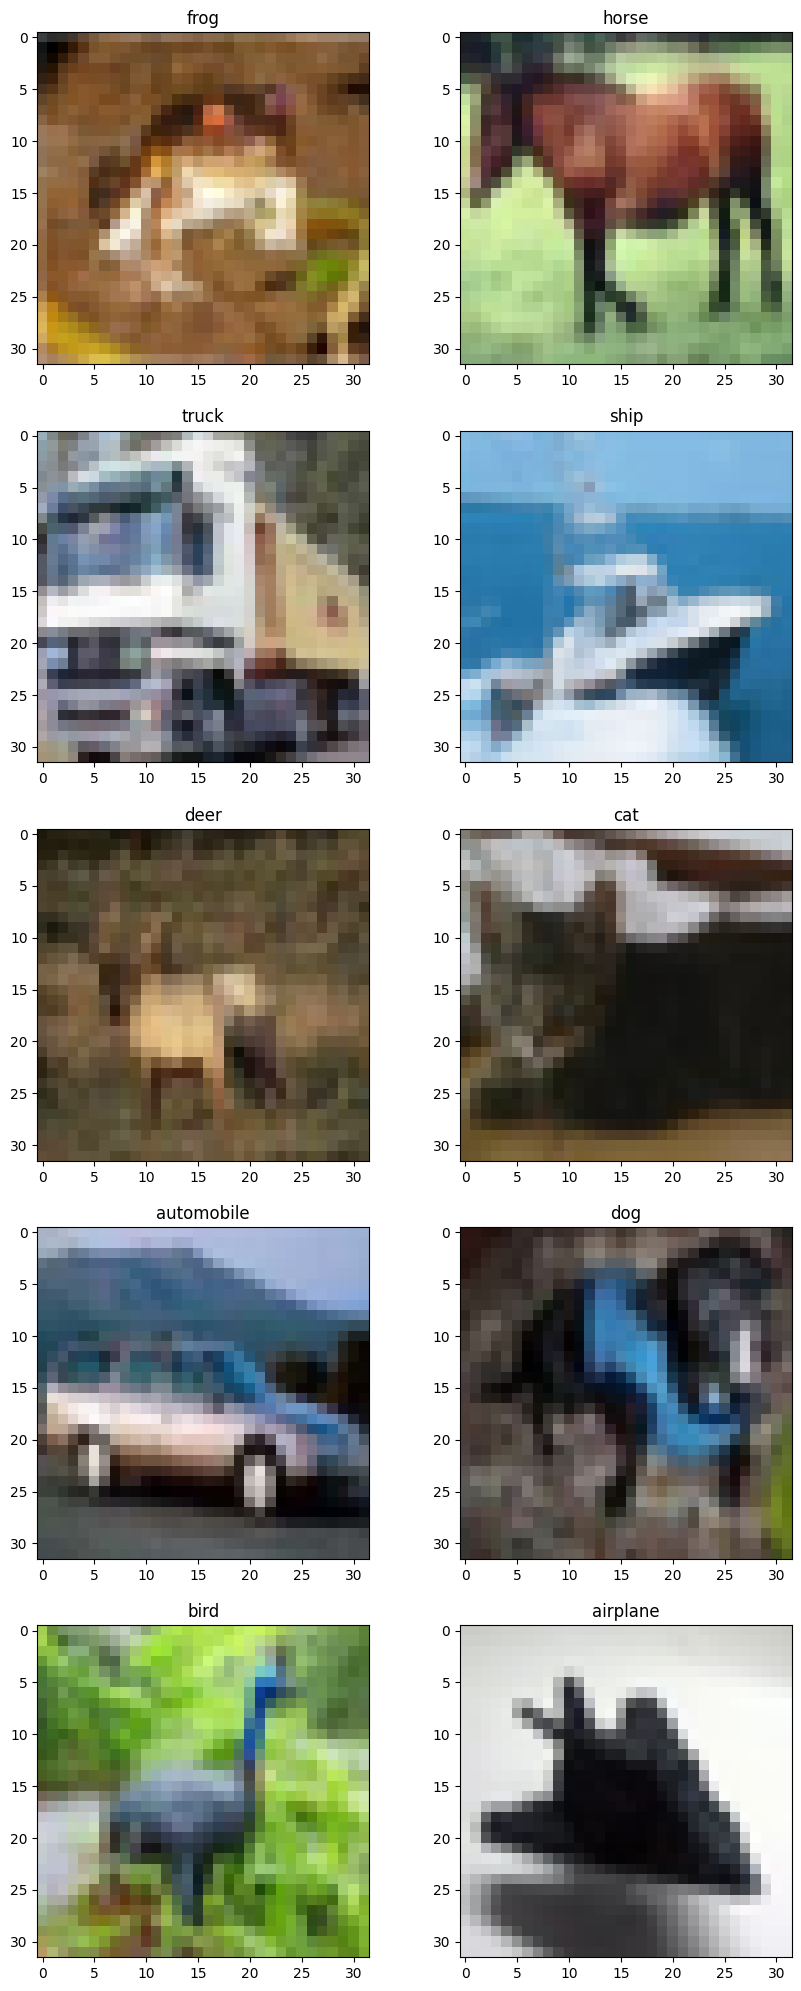

In [ ]:
data_per_label = data.loc[data["label"].duplicated()==False]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,25))

for i in range(5):
  for j in range(2):
    filename = "./train/" + data_per_label.iloc[i+j*5,0]
    image = Image.open(filename)
    axes[i,j].imshow(image)
    axes[i,j].title.set_text(data_per_label.iloc[i+j*5,1])

* Define the transformations you will be applying to your images. Use a target size of `(32,32)

In [10]:
# Apply a series of transformations to the images
transform = transforms.Compose([
    #transforms.RandomRotation(180),  # Randomly rotate images up to 180 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # # Randomly flip images vertically
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Randomly adjust brightness and contrast
    transforms.Resize([32,32]), # Resize images to 32x32 pixels
    transforms.ToTensor(), # Convert images to tensors
])

* Set up one generator for the train data and one for the test data using the method that lets you generate data with a dataframe. Since we have many images in this dataset, we will create large batches of 64 images.

In [24]:
# Define a custom PyTorch Dataset class for loading images

# Create a dictionary mapping class labels to indices
classes_map = {label : index for index, label in enumerate(data["label"].unique())}

class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None): # Initialize the dataset with a DataFrame, image directory, and optional transformations
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Return the number of samples in the dataset
        return len(self.dataframe)

    def __getitem__(self, idx): 
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0]) # Load an image file and retrieve its corresponding label
        image = Image.open(img_name)
        label = classes_map[self.dataframe.loc[idx, "label"]]
        if self.transform: # Apply transformations if specified
            image = self.transform(image)
        return image, label # Return the transformed image and its label

# Create a dataset instance using the DataFrame and image directory
df_dataset = ImageDataset(dataframe=data, img_dir="./train", transform=transform)

# Split dataset into training (80%) and validation (20%) subsets
train_size = int(0.8 * len(df_dataset))
val_size = int(0.2 * len(df_dataset))
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
next(iter(train_loader))

[tensor([[[[0.5647, 0.5216, 0.4706,  ..., 0.4627, 0.4784, 0.4706],
           [0.5529, 0.5333, 0.4902,  ..., 0.4745, 0.4863, 0.4863],
           [0.5804, 0.5608, 0.5529,  ..., 0.5137, 0.5137, 0.5020],
           ...,
           [0.2314, 0.2314, 0.2275,  ..., 0.2431, 0.2471, 0.2431],
           [0.2275, 0.2314, 0.2314,  ..., 0.2471, 0.2471, 0.2431],
           [0.2275, 0.2314, 0.2275,  ..., 0.2471, 0.2471, 0.2549]],
 
          [[0.5255, 0.4824, 0.4275,  ..., 0.4392, 0.4549, 0.4549],
           [0.5176, 0.4902, 0.4549,  ..., 0.4549, 0.4627, 0.4627],
           [0.5333, 0.5176, 0.5137,  ..., 0.4902, 0.4863, 0.4784],
           ...,
           [0.2275, 0.2275, 0.2235,  ..., 0.2392, 0.2431, 0.2392],
           [0.2235, 0.2275, 0.2275,  ..., 0.2431, 0.2431, 0.2392],
           [0.2235, 0.2275, 0.2235,  ..., 0.2471, 0.2471, 0.2471]],
 
          [[0.4275, 0.4000, 0.3647,  ..., 0.3647, 0.3765, 0.3647],
           [0.3961, 0.3843, 0.3608,  ..., 0.3686, 0.3725, 0.3686],
           [0.4078, 0.39

* Display a batch of data of train data

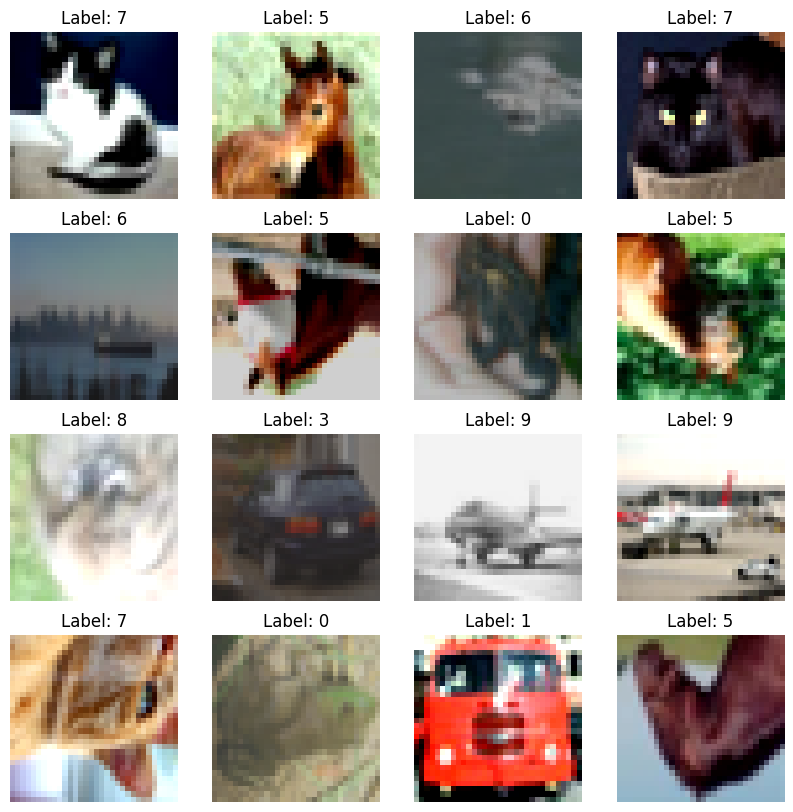

In [ ]:
images, labels = next(iter(train_loader))

fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy()
    ax[i // 4, i % 4].imshow(img)
    ax[i // 4, i % 4].set_title(f"Label: {labels[i]}")
    ax[i // 4, i % 4].axis("off")

plt.show()

* How many times can you divide the images by two along each axis until you reduce the images to single pixel?

In [21]:
a = 32

while a>1 :
  print(a, "->" , a/2)
  a=a/2

32 -> 16.0
16.0 -> 8.0
8.0 -> 4.0
4.0 -> 2.0
2.0 -> 1.0


* Build a neural network with a single convolution layer with 32 neurons, kernel size `(3,3)`, padding `"same"`, and activation `"relu"`, a max pooling layer, a flatten layer, then finish up the network with a dense layer that can predict the target variable.

In [23]:
# Define a simple CNN model in PyTorch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layer: 32 filters, kernel size 3x3, padding "same"
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.flatten = nn.Flatten()  # Flatten layer
        self.fc = nn.Linear(32 * 16 * 16, 10)  # Fully connected layer for 10 classes
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for classification
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))  # Apply ReLU activation to the convolution output
        x = self.pool(x)  # Apply max pooling
        x = self.flatten(x)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        x = self.softmax(x)  # Apply softmax activation
        return x

# Instantiate the model
model = CNN()
print(model)  # Print model summary

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=8192, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:

# Print model summary
summary(model, input_size=(1, 3, 32, 32))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Flatten: 1-3                           [1, 8192]                 --
├─Linear: 1-4                            [1, 10]                   81,930
├─Softmax: 1-5                           [1, 10]                   --
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 1.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.26
Params size (MB): 0.33
Estimated Total Size (MB): 0.61

* Compile the model using the right loss function and metric(s) and the Adam optimizer with default learning rate

In [31]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with default learning rate

* Train the model over 50 epochs

In [32]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    """
    Function to train a PyTorch model with training and validation datasets.
    
    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).
    
    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """
    
    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters
            
            total_loss += loss.item()  # Accumulate batch loss
            correct += (torch.argmax(outputs,dim=1) == labels).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += (torch.argmax(outputs,dim=1) == labels).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50)

Epoch [1/50], Loss: 2.1542, Acc: 0.3041, Val Loss: 2.1020, Val Acc: 0.3618
Epoch [2/50], Loss: 2.0839, Acc: 0.3761, Val Loss: 2.0634, Val Acc: 0.3942
Epoch [3/50], Loss: 2.0531, Acc: 0.4071, Val Loss: 2.0476, Val Acc: 0.4160
Epoch [4/50], Loss: 2.0331, Acc: 0.4297, Val Loss: 2.0332, Val Acc: 0.4277
Epoch [5/50], Loss: 2.0170, Acc: 0.4449, Val Loss: 2.0087, Val Acc: 0.4522
Epoch [6/50], Loss: 2.0063, Acc: 0.4570, Val Loss: 2.0198, Val Acc: 0.4377
Epoch [7/50], Loss: 1.9954, Acc: 0.4653, Val Loss: 1.9982, Val Acc: 0.4644
Epoch [8/50], Loss: 1.9879, Acc: 0.4741, Val Loss: 1.9919, Val Acc: 0.4725
Epoch [9/50], Loss: 1.9809, Acc: 0.4814, Val Loss: 1.9913, Val Acc: 0.4666
Epoch [10/50], Loss: 1.9734, Acc: 0.4886, Val Loss: 2.0115, Val Acc: 0.4454
Epoch [11/50], Loss: 1.9651, Acc: 0.4982, Val Loss: 1.9907, Val Acc: 0.4709
Epoch [12/50], Loss: 1.9602, Acc: 0.5016, Val Loss: 1.9724, Val Acc: 0.4867
Epoch [13/50], Loss: 1.9565, Acc: 0.5043, Val Loss: 1.9713, Val Acc: 0.4894
Epoch [14/50], Loss: 

* Save the model under `cifar10model1conv.h5`

In [33]:
# Save model checkpoint 
checkpoint_path = "model_conv1.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': history["val_loss"][-1],
    'history': history 
}, checkpoint_path)

* You may get the model's history with this code (for instructors not to have to train the whole model during the session)

In [34]:
url="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_conv1.pth"
output_path="model_conv1.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

* Load the history .json file using the following command (for instructors)

In [35]:
restored_model_pooling = CNN()  # Ensure the same architecture
restored_model_pooling.load_state_dict(torch.load("model_conv1.pth", weights_only=True)["model_state_dict"])
restored_model_pooling.eval()
history = torch.load("model_conv1.pth", weights_only=True)["history"]

* Display the evolution of the loss and the validation loss using plotly

In [ ]:
# Import the necessary module from Plotly for data visualization
from plotly import graph_objects as go

# Create a figure object to hold the plot
fig = go.Figure(
    data=[
        # Add a scatter plot for training loss
        go.Scatter(
            # - 'y' represents the training loss values over epochs
            y=history["loss"],
            # - 'name' is the label for the legend
            name="Training loss",
            # - 'mode' is set to "lines" to create a line plot
            mode="lines",
            ),
        # Add a scatter plot for validation loss
        go.Scatter(
            # - 'y' represents the validation loss values over epochs
            y=history["val_loss"],
            # - 'name' is the label for the legend
            name="Validation loss",
            # - 'mode' is set to "lines" to create a line plot
            mode="lines",
            )
])

# Customize the layout of the figure
fig.update_layout(
    # - Set the title of the plot
    title='Training and val loss across epochs',
    # - Label the x-axis as 'epochs'
    xaxis_title='epochs',
    # - Label the y-axis as 'Cross Entropy' to represent loss values
    yaxis_title='Cross Entropy'    
)

# Display the plot
fig.show()


The model looks it starts to overfit after 30 epochs and it trains smoothly on the training data.

* Build a new model and add a new convolution layer with double the number of neurons on it followed by a max pooling, and reproduce all the same steps as before.

In [37]:
# Define a simple CNN model in PyTorch
class CNN2(nn.Module):

    # Initialize the model architecture
    def __init__(self):
        super(CNN2, self).__init__()
        # First convolutional layer:
        # - 32 filters
        # - Kernel size 3x3
        # - Padding set to "same" to maintain spatial dimensions
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        # First max pooling layer:
        # - Pool size 2x2
        # - Stride 2 to reduce spatial dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer:
        # - 64 filters
        # - Kernel size 3x3
        # - Padding set to "same"
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        # Second max pooling layer:
        # - Pool size 2x2
        # - Stride 2 to further reduce spatial dimensions
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten the feature maps into a single vector for the fully connected layer
        self.flatten = nn.Flatten()
        # Fully connected layer:
        # - Takes the flattened features as input
        # - Outputs 10 classes for classification
        self.fc = nn.Linear(64 * 8 * 8, 10)
        # Softmax activation function:
        # - Converts raw scores into probabilities for classification
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for classification
    
    # Define the forward pass:
    def forward(self, x):
        # - Apply ReLU activation after each convolutional layer
        x = torch.relu(self.conv1(x))
        # - Apply max pooling after each convolutional layer
        x = self.pool1(x)
        # - Apply ReLU activation after each convolutional layer
        x = torch.relu(self.conv2(x))
        # - Apply max pooling after each convolutional layer
        x = self.pool2(x)
        # - Flatten the output before passing it to the fully connected layer
        x = self.flatten(x)  # Flatten the feature maps
        # - Fully connected layer
        x = self.fc(x)
        # - Apply softmax to get class probabilities
        x = self.softmax(x)
        return x

# Instantiate the model
model_conv2 = CNN2()
# Print model summary to visualize the architecture
print(model_conv2)  # Print model summary

CNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [38]:
# Print model summary
summary(model_conv2, input_size=(1, 3, 32, 32))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
CNN2                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Flatten: 1-5                           [1, 4096]                 --
├─Linear: 1-6                            [1, 10]                   40,970
├─Softmax: 1-7                           [1, 10]                   --
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
Total mult-adds (M): 5.69
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.24
Estimated Total Size (MB): 0.65

In [39]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable loss function for multi-class classification
optimizer2 = optim.Adam(model_conv2.parameters(), lr=0.001)  # Adam optimizer with default learning rate

history2 = train(model_conv2,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer2,
                epochs=50)

Epoch [1/50], Loss: 2.1518, Acc: 0.3028, Val Loss: 2.1205, Val Acc: 0.3328
Epoch [2/50], Loss: 2.0765, Acc: 0.3783, Val Loss: 2.0579, Val Acc: 0.3977
Epoch [3/50], Loss: 2.0468, Acc: 0.4116, Val Loss: 2.0262, Val Acc: 0.4337
Epoch [4/50], Loss: 2.0292, Acc: 0.4283, Val Loss: 2.0138, Val Acc: 0.4429
Epoch [5/50], Loss: 2.0105, Acc: 0.4477, Val Loss: 2.0048, Val Acc: 0.4547
Epoch [6/50], Loss: 1.9985, Acc: 0.4601, Val Loss: 2.0057, Val Acc: 0.4516
Epoch [7/50], Loss: 1.9833, Acc: 0.4749, Val Loss: 1.9853, Val Acc: 0.4745
Epoch [8/50], Loss: 1.9717, Acc: 0.4869, Val Loss: 1.9729, Val Acc: 0.4837
Epoch [9/50], Loss: 1.9589, Acc: 0.5009, Val Loss: 1.9624, Val Acc: 0.4937
Epoch [10/50], Loss: 1.9506, Acc: 0.5082, Val Loss: 1.9557, Val Acc: 0.5022
Epoch [11/50], Loss: 1.9476, Acc: 0.5112, Val Loss: 1.9686, Val Acc: 0.4881
Epoch [12/50], Loss: 1.9418, Acc: 0.5177, Val Loss: 1.9540, Val Acc: 0.5030
Epoch [13/50], Loss: 1.9356, Acc: 0.5230, Val Loss: 1.9528, Val Acc: 0.5051
Epoch [14/50], Loss: 

In [40]:
# Save model checkpoint 
checkpoint_path = "model_conv2.pth"
torch.save({
    'model_state_dict': model_conv2.state_dict(),
    'optimizer_state_dict': optimizer2.state_dict(),
    'val_loss': history2["val_loss"][-1],
    'history': history2 
}, checkpoint_path)

In [41]:
url="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_conv2.pth"
output_path="model_conv2.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

In [42]:
restored_model_pooling = CNN2()  # Ensure the same architecture
restored_model_pooling.load_state_dict(torch.load("model_conv2.pth", weights_only=True)["model_state_dict"])
restored_model_pooling.eval()
history = torch.load("model_conv2.pth", weights_only=True)["history"]

In [43]:
from plotly import graph_objects as go

fig = go.Figure(
    data=[
        go.Scatter(
            y=history["loss"],
            name="Training loss",
            mode="lines",
            ),
        go.Scatter(
            y=history["val_loss"],
            name="Validation loss",
            mode="lines",
            )
])

fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)

fig.show()

Here it seems pretty clear that just by adding a second convolutional layer in our network we are able to reach lower values of the loss function in fewer epochs, and despite the fact that our second model has much fewer parameters!

* Repeat the same steps adding a third convolutional layer with `128` neurons on it, followed my a max pooling layer.

In [44]:
# Define a CNN model with three convolutional layers in PyTorch
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        # First convolutional layer: 32 filters, kernel size 3x3, padding "same"
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        # Second convolutional layer: 64 filters
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        # Third convolutional layer: 128 filters
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 10)  # Fully connected layer for 10 classes
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for classification
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Instantiate the model
model_conv3 = CNN3()
print(model_conv3)

CNN3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [45]:
# Print model summary
summary(model_conv3, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Conv2d: 1-5                            [1, 128, 8, 8]            73,856
├─MaxPool2d: 1-6                         [1, 128, 4, 4]            --
├─Flatten: 1-7                           [1, 2048]                 --
├─Linear: 1-8                            [1, 10]                   20,490
├─Softmax: 1-9                           [1, 10]                   --
Total params: 113,738
Trainable params: 113,738
Non-trainable params: 0
Total mult-adds (M): 10.40
Input size (MB): 0.01
Forward/backward pass size (MB): 0.46
Params size (MB): 0.45
Estimated Total Size (MB): 0.9

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model_conv3.parameters(), lr=0.001)

# Train the model
history3 = train(model_conv3, train_loader, val_loader, criterion, optimizer3, epochs=50)

Epoch [1/50], Loss: 2.1621, Acc: 0.2865, Val Loss: 2.0876, Val Acc: 0.3634
Epoch [2/50], Loss: 2.0559, Acc: 0.3985, Val Loss: 2.0392, Val Acc: 0.4187
Epoch [3/50], Loss: 2.0150, Acc: 0.4404, Val Loss: 2.0244, Val Acc: 0.4305
Epoch [4/50], Loss: 1.9813, Acc: 0.4753, Val Loss: 1.9638, Val Acc: 0.4974
Epoch [5/50], Loss: 1.9549, Acc: 0.5029, Val Loss: 1.9528, Val Acc: 0.5068
Epoch [6/50], Loss: 1.9387, Acc: 0.5184, Val Loss: 1.9322, Val Acc: 0.5236
Epoch [7/50], Loss: 1.9210, Acc: 0.5369, Val Loss: 1.9136, Val Acc: 0.5439
Epoch [8/50], Loss: 1.9056, Acc: 0.5525, Val Loss: 1.9010, Val Acc: 0.5586
Epoch [9/50], Loss: 1.8954, Acc: 0.5639, Val Loss: 1.8931, Val Acc: 0.5646
Epoch [10/50], Loss: 1.8848, Acc: 0.5742, Val Loss: 1.9242, Val Acc: 0.5351
Epoch [11/50], Loss: 1.8763, Acc: 0.5819, Val Loss: 1.8756, Val Acc: 0.5846
Epoch [12/50], Loss: 1.8658, Acc: 0.5926, Val Loss: 1.8761, Val Acc: 0.5825
Epoch [13/50], Loss: 1.8609, Acc: 0.5969, Val Loss: 1.8862, Val Acc: 0.5713
Epoch [14/50], Loss: 

In [ ]:
# Save model checkpoint
checkpoint_path = "model_conv3.pth"
torch.save({
    'model_state_dict': model_conv3.state_dict(),
    'optimizer_state_dict': optimizer3.state_dict(),
    'val_loss': history3["val_loss"][-1],
    'history': history3
}, checkpoint_path)

In [46]:
url = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_conv3.pth"
output_path = "model_conv3.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

Download complete.


In [47]:
# Load the model from checkpoint
restored_model_conv3 = CNN3()
restored_model_conv3.load_state_dict(torch.load("model_conv3.pth", weights_only=True)["model_state_dict"])
restored_model_conv3.eval()
history = torch.load("model_conv3.pth", weights_only=True)["history"]

In [48]:
fig = go.Figure(data=[
    go.Scatter(
        y=history["loss"],
        name="Training loss",
        mode="lines"
    ),
    go.Scatter(
        y=history["val_loss"],
        name="Validation loss",
        mode="lines"
    )
])

fig.update_layout(
    title='Training and Validation Loss Across Epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)

fig.show()

* Let's build the same model and double the number of convolutional neurons on each layer.

In [49]:
# Define a CNN model with doubled neurons in each convolutional layer
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 4 * 4, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Instantiate the model
model_conv4 = CNN4()
print(model_conv4)

CNN4(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [50]:
# Print model summary
summary(model_conv4, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN4                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           --
├─Conv2d: 1-3                            [1, 128, 16, 16]          73,856
├─MaxPool2d: 1-4                         [1, 128, 8, 8]            --
├─Conv2d: 1-5                            [1, 256, 8, 8]            295,168
├─MaxPool2d: 1-6                         [1, 256, 4, 4]            --
├─Flatten: 1-7                           [1, 4096]                 --
├─Linear: 1-8                            [1, 10]                   40,970
├─Softmax: 1-9                           [1, 10]                   --
Total params: 411,786
Trainable params: 411,786
Non-trainable params: 0
Total mult-adds (M): 39.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.92
Params size (MB): 1.65
Estimated Total Size (MB): 

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model_conv4.parameters(), lr=0.001)

# Train the model
history4 = train(model_conv4, train_loader, val_loader, criterion, optimizer4, epochs=50)

Epoch [1/50], Loss: 2.1537, Acc: 0.2948, Val Loss: 2.1057, Val Acc: 0.3440
Epoch [2/50], Loss: 2.0533, Acc: 0.4022, Val Loss: 2.0591, Val Acc: 0.3950
Epoch [3/50], Loss: 2.0129, Acc: 0.4443, Val Loss: 2.0270, Val Acc: 0.4314
Epoch [4/50], Loss: 1.9795, Acc: 0.4759, Val Loss: 1.9703, Val Acc: 0.4866
Epoch [5/50], Loss: 1.9508, Acc: 0.5050, Val Loss: 1.9757, Val Acc: 0.4835
Epoch [6/50], Loss: 1.9351, Acc: 0.5219, Val Loss: 1.9323, Val Acc: 0.5248
Epoch [7/50], Loss: 1.9206, Acc: 0.5379, Val Loss: 1.9094, Val Acc: 0.5484
Epoch [8/50], Loss: 1.9099, Acc: 0.5475, Val Loss: 1.9221, Val Acc: 0.5347
Epoch [9/50], Loss: 1.9033, Acc: 0.5544, Val Loss: 1.9031, Val Acc: 0.5544
Epoch [10/50], Loss: 1.8882, Acc: 0.5706, Val Loss: 1.9111, Val Acc: 0.5471
Epoch [11/50], Loss: 1.8776, Acc: 0.5811, Val Loss: 1.8897, Val Acc: 0.5683
Epoch [12/50], Loss: 1.8746, Acc: 0.5844, Val Loss: 1.8920, Val Acc: 0.5655
Epoch [13/50], Loss: 1.8748, Acc: 0.5829, Val Loss: 1.8892, Val Acc: 0.5696
Epoch [14/50], Loss: 

In [ ]:
# Save model checkpoint
checkpoint_path = "model_conv4.pth"
torch.save({
    'model_state_dict': model_conv4.state_dict(),
    'optimizer_state_dict': optimizer4.state_dict(),
    'val_loss': history4["val_loss"][-1],
    'history': history4
}, checkpoint_path)

In [51]:
url = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_conv4.pth"
output_path = "model_conv4.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

Download complete.


In [52]:
# Load the model from checkpoint
restored_model_conv4 = CNN4()
restored_model_conv4.load_state_dict(torch.load("model_conv4.pth", weights_only=True)["model_state_dict"])
restored_model_conv4.eval()
history = torch.load("model_conv4.pth", weights_only=True)["history"]

In [53]:
# Plot training and validation loss
fig = go.Figure(data=[
    go.Scatter(
        y=history["loss"],
        name="Training loss",
        mode="lines"
    ),
    go.Scatter(
        y=history["val_loss"],
        name="Validation loss",
        mode="lines"
    )
])
fig.update_layout(
    title='Training and Validation Loss Across Epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Increasing the number of neurons on each layer is causing the model to quickly overfit! But it trains really on the training data.

* In the time remaining, build a model by duplicating the convolutional layers before every maxpooling adn go back to the original number of neurons. Look at the model summary for reference. This last model will have 6 different convolutional layers, let's see the effect of this on the predictions

In [54]:
# Define a CNN model with six convolutional layers in PyTorch
class CNN6(nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        # First two convolutional layers: 32 filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second two convolutional layers: 64 filters
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third two convolutional layers: 128 filters
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 10)  # Fully connected layer for 10 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(x)

        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Instantiate the model
model_conv6 = CNN6()
print(model_conv6)

CNN6(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [55]:
# Print model summary
summary(model_conv6, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN6                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─Conv2d: 1-2                            [1, 32, 32, 32]           9,248
├─MaxPool2d: 1-3                         [1, 32, 16, 16]           --
├─Conv2d: 1-4                            [1, 64, 16, 16]           18,496
├─Conv2d: 1-5                            [1, 64, 16, 16]           36,928
├─MaxPool2d: 1-6                         [1, 64, 8, 8]             --
├─Conv2d: 1-7                            [1, 128, 8, 8]            73,856
├─Conv2d: 1-8                            [1, 128, 8, 8]            147,584
├─MaxPool2d: 1-9                         [1, 128, 4, 4]            --
├─Flatten: 1-10                          [1, 2048]                 --
├─Linear: 1-11                           [1, 10]                   20,490
├─Softmax: 1-12                          [1, 10]            

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer6 = optim.Adam(model_conv6.parameters(), lr=0.001)

# Train the model
history6 = train(model_conv6, train_loader, val_loader, criterion, optimizer6, epochs=50)

Epoch [1/50], Loss: 2.2139, Acc: 0.2282, Val Loss: 2.1482, Val Acc: 0.3052
Epoch [2/50], Loss: 2.1345, Acc: 0.3180, Val Loss: 2.0913, Val Acc: 0.3626
Epoch [3/50], Loss: 2.0978, Acc: 0.3554, Val Loss: 2.0739, Val Acc: 0.3810
Epoch [4/50], Loss: 2.0629, Acc: 0.3916, Val Loss: 2.1007, Val Acc: 0.3524
Epoch [5/50], Loss: 2.0425, Acc: 0.4124, Val Loss: 2.0353, Val Acc: 0.4203
Epoch [6/50], Loss: 2.0286, Acc: 0.4272, Val Loss: 2.0635, Val Acc: 0.3885
Epoch [7/50], Loss: 2.0061, Acc: 0.4495, Val Loss: 1.9941, Val Acc: 0.4636
Epoch [8/50], Loss: 1.9954, Acc: 0.4603, Val Loss: 1.9877, Val Acc: 0.4669
Epoch [9/50], Loss: 1.9759, Acc: 0.4806, Val Loss: 1.9751, Val Acc: 0.4818
Epoch [10/50], Loss: 1.9761, Acc: 0.4808, Val Loss: 1.9638, Val Acc: 0.4938
Epoch [11/50], Loss: 1.9683, Acc: 0.4890, Val Loss: 1.9535, Val Acc: 0.5055
Epoch [12/50], Loss: 1.9645, Acc: 0.4933, Val Loss: 1.9774, Val Acc: 0.4811
Epoch [13/50], Loss: 1.9700, Acc: 0.4882, Val Loss: 1.9816, Val Acc: 0.4782
Epoch [14/50], Loss: 

In [ ]:
# Save model checkpoint
checkpoint_path = "model_conv6.pth"
torch.save({
    'model_state_dict': model_conv6.state_dict(),
    'optimizer_state_dict': optimizer6.state_dict(),
    'val_loss': history6["val_loss"][-1],
    'history': history6
}, checkpoint_path)

In [56]:
url = "https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/model_conv6.pth"
output_path = "model_conv6.pth"

# Download the file
if not os.path.exists(output_path):
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

Download complete.


In [57]:
# Load the model from checkpoint
restored_model_conv6 = CNN6()
restored_model_conv6.load_state_dict(torch.load("model_conv6.pth", weights_only=True)["model_state_dict"])
restored_model_conv6.eval()
history = torch.load("model_conv6.pth", weights_only=True)["history"]

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

Adding more convolutional layers helps a little but does not really improve the results for this dataset.